### Flat rating

O ponto de Flat rating é o qual, dada uma temperatura ambiente e considerando que o motor fornece a potência limitada pela caixa de redução, é possível obter a temperatura na saída da câmara de combustão igual àquela estipulada para calibração do motor inicial, que neste caso é igual à 1400 K.

Assim para obter este ponto, no código, a temperatura ambiente foi variada de 0.1 em 0.1 partindo de 288.2K, sendo que para cada temperatura a rotação N2 foi variada encontrando a rotação que permite o motor fornecer a potência limitante de 1282 kW. Ao encontrar essa rotação também foi obtida a temperatura da saída de combustão, a qual foi comparada com a temperatura de 1400 K. O ponto de flat-rating, portanto, foi a temperatura ambiente para a qual obteve-se a temperatura de saída da câmara de combustão igual à 1400 K. 

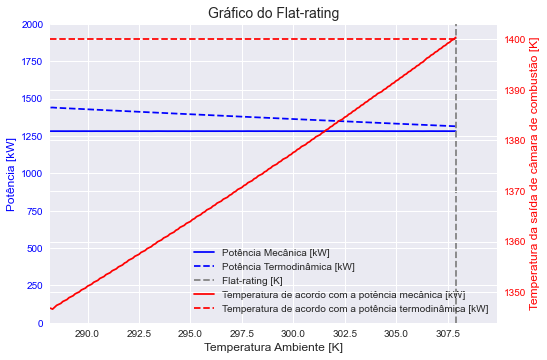

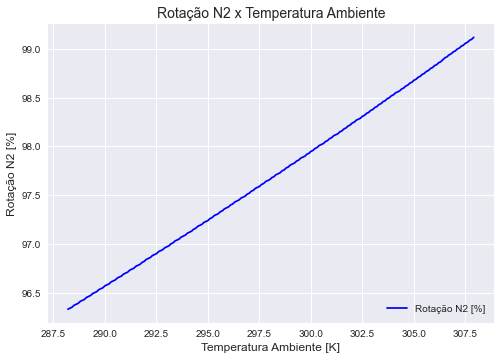

Temperatura do ponto de flat-rating:  307.90000000000447


,0.9913
BSFC,0.000087
EBSFC,0.000087
TSFC,0.070919
aircraft_speed,0.000000
fuel_consumption,0.111912
gearbox_power,1256.581801
mass_flow,6.208030
specific_power_turbine,206.543195
specific_thrust,0.254191
thrust_hot_air,1.578025


In [62]:
import model_reference as mf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import warnings


# Set style
plt.style.use("seaborn")
warnings.filterwarnings('ignore')

values = {
    'mass_flow': 6.7,  
    't04': 1400,       
    'prc': 12,         
    'mach': 0,         
    'ta': 288.2,       
    'pa': 101.3,       
    'n_d': 0.85,       
    'gamma_d': 1.4,    
    'n_c': 0.75,       
    'gamma_c': 1.37,   
    'n_b': 1,          
    'gamma_b': 1.35,   
    'n_t': 0.9,        
    'gamma_t': 1.33,   
    'n_tl': 0.9,       
    'gamma_tl': 1.33,  
    'n_n': 0.98,       
    'gamma_n': 1.36,   
    'pc_fuel': 45000,  
    'cp_fuel': 1.110,  
    'cp_tls': 1.160,
    'cp_tl': 1.110,  
    'r': 288.3,        
    'pr_tl': 2.3528,                    
    'gearbox_power_ratio': 0.98,  
    'propeller_efficiency': 0.85, 
    }

values['pr_tl'] = 2.3528    # Value found in 4a for Ta = 288.2K, N2 = 1, T04 = 1400K
T04_target = 1400           # Temperature T04 of operation ou 1417.668
N2 = 0.9633                 # Value found in 4a for Ta = 288.2K
N2_delta = 0.0001           # Delta N2
Ta = 288.2                  # Temperature Ta for ISA
Ta_delta = 0.1              # Delta Ta
turbine_power_target = 1282 # Limite of gearbox power

# Flags to break loops
found_flat_rating = False
found_N2_to_Ta = False

# Results
TAs = []
N2s = []

target = ['t04', 'BSFC', 't05', 'fuel_consumption', 'turbine_power']
target_op = ['t04', 'turbine_power']

values['ta'] = Ta
turboprop = mf.TurboProp(values)
results = (turboprop.sumarise().append(turboprop.sumarise_results()).loc[target])
results_op = (turboprop.sumarise().append(turboprop.sumarise_results()).loc[target_op])

index = 0

while not found_flat_rating:
    found_N2_to_Ta = False
    values['ta'] = Ta
    turboprop = mf.TurboProp(values)

    # Get result for Ta when N2 = 100%
    turboprop.set_n2(1)
    results_op[index] = (turboprop.sumarise().append(turboprop.sumarise_results()).loc[target_op])

    while not found_N2_to_Ta:
        N2 = N2 + N2_delta
        turboprop.set_n2(N2)
        performance_results = turboprop.sumarise_results()
        if float(performance_results.loc['turbine_power']) > turbine_power_target:
            found_N2_to_Ta = True
            N2 = N2 - N2_delta
        elif float(performance_results.loc['turbine_power']) == turbine_power_target:
            found_N2_to_Ta = True

    # Get result for Ta and N2 when mecanic power is 1282kW
    turboprop.set_n2(N2)
    results[index] = (turboprop.sumarise().append(turboprop.sumarise_results()).loc[target])
    TAs.append(Ta)
    N2s.append(N2)

    # When T04 calculated is equal to 1400K, so is flat rating
    if float(results[index].loc['t04']) >= T04_target:
        found_flat_rating = True
    else:
        Ta = Ta +Ta_delta # Update Ta

    # Update index of results
    index = index +1

results = results.loc[target]
results_op = results_op.loc[target_op]  

# Plot informations
'''
    Flat-rating Graph 
'''
# create figure and axis objects with subplots()
fig,ax = plt.subplots()
# set title
plt.title("Gráfico do Flat-rating",fontsize=14)
# make a plot
plot1, = ax.plot(TAs, results.iloc[4], color="blue", label='Potência Mecânica [kW]')
plot2, = ax.plot(TAs, results_op.iloc[1], 'b--', label='Potência Termodinâmica [kW]')
plot3 = ax.vlines(x = max(TAs), ymin= 0, ymax= 2000, color ='gray', linestyle='--', label='Flat-rating [K]')
# set x-axis label
ax.set_xlabel("Temperatura Ambiente [K]",fontsize=12)
# set y-axis label
ax.set_ylabel("Potência [kW]",color="blue",fontsize=12)
# set y-axis color
ax.tick_params(axis ='y', labelcolor = 'blue')
# set y-axis limits
ax.set_ylim(0,2000)

# set x-axis limits
ax.set_xlim(min(TAs),max(TAs)+2)

# twin object for two different y-axis on the sample plot
ax2=ax.twinx()
# make a plot with different y-axis using second axis object
plot4, = ax2.plot(TAs,  results.iloc[0], color="red", label='Temperatura de acordo com a potência mecânica [kW]')
plot5 = ax2.hlines(y = T04_target, xmin= min(TAs), xmax= max(TAs), color ='red', linestyle='--', label='Temperatura de acordo com a potência termodinâmica [kW]')

# set y-axis label
ax2.set_ylabel("Temperatura da saída de câmara de combustão [K]",color="red",fontsize=12)
# set y-axis color
ax2.tick_params(axis ='y', labelcolor = 'red')

# Add legends
ax.legend(handles=[plot1, plot2, plot3, plot4, plot5], loc='lower right')

# Show plot
plt.show()

# save the plot as a file
fig.savefig('images/questao4/flat_rating.jpg',
            format='jpeg',
            dpi=100,
            bbox_inches='tight')


'''
    N2 x Temperatura Ambiente Graph
'''
# create figure and axis objects with subplots()
fig2,ax = plt.subplots()
# set title
plt.title("Rotação N2 x Temperatura Ambiente",fontsize=14)
# make a plot
ax.plot(TAs, [x * 100 for x in N2s] , color="blue", label='Rotação N2 [%]')
# set x-axis label
ax.set_xlabel("Temperatura Ambiente [K]",fontsize=12)
# set y-axis label
ax.set_ylabel("Rotação N2 [%]",fontsize=12)
# Add legends
ax.legend(loc='lower right')

# Show plot
plt.show()

# save the plot as a file
fig2.savefig('images/questao4/rotacao_tempAmb.jpg',
            format='jpeg',
            dpi=100,
            bbox_inches='tight')

print("Temperatura do ponto de flat-rating: ", max(TAs))

performance_results

Analisando as potências apresentadas no gráfico Flat-rating, percebe-se que a medida que a temperatura ambiente aumenta a potência termodinâmica, que é a potência máxima que o motor consegue fornecer para aquela temperatura ambiente a uma rotação em 100%, diminui. Isso demonstra que o aumento da temperatura ambiente faz com que o motor se torne menos eficiente, entregando menor potência. No entanto, a potência mecânica observada e que é a potência efetiva que o motor entrega é limitada à potência máxima suportada pela caixa de redução. 

Visto que a eficiência do motor cai, a medida que a temperatura ambiente aumenta, é necessário uma maior rotação para obter a potência máxima suportada pela caixa de redução, o que é observado no gráfico Rotação N2 x Temperatura Ambiente.

Como a rotação aumenta a medida que a temperatura ambiente aumenta, a temperatura na saída da câmara de combustão também aumenta até o ponto de flat-rating, em que se alcança essa temperatura igual à 1400K. No gráfico de flat-rating observa-se que neste ponto a máxima potência termodinâmica possível dada aquelas condições não é igual à potência efetiva entregue a caixa de redução, pois a rotação neste ponto não é a máxima possível.

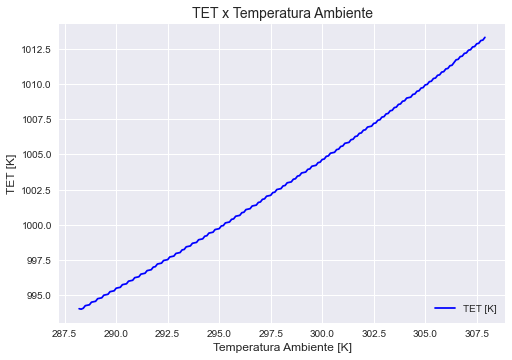

In [63]:
'''
    TET x Temperatura Ambiente Graph
'''
# create figure and axis objects with subplots()
fig4,ax = plt.subplots()
# set title
plt.title("TET x Temperatura Ambiente",fontsize=14)
# make a plot
ax.plot(TAs, results.iloc[2], color="blue", label='TET [K]')
# set x-axis label
ax.set_xlabel("Temperatura Ambiente [K]",fontsize=12)
# set y-axis label
ax.set_ylabel("TET [K]",fontsize=12)

# Add legends
ax.legend(loc='lower right')

# Show plot
plt.show()

# save the plot as a file
fig4.savefig('images/questao4/TET_tempAmb.jpg',
            format='jpeg',
            dpi=100,
            bbox_inches='tight')


Como a temperatura na saída da câmara de combustão aumenta com o aumento da temperatura ambiente, a temperatura entre turbinas que depende da temperatura na saída da câmra de combustão também aumenta.

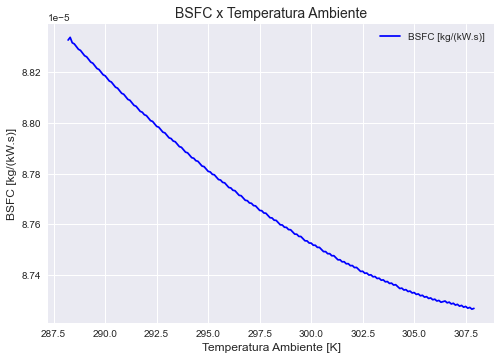

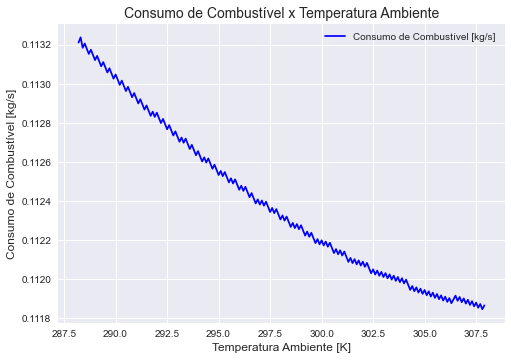

In [64]:
'''
    BSFC x Temperatura Ambiente Graph 
'''
# create figure and axis objects with subplots()
fig3,ax = plt.subplots()
# set title
plt.title("BSFC x Temperatura Ambiente",fontsize=14)
# make a plot
ax.plot(TAs, results.iloc[1], color="blue", label='BSFC [kg/(kW.s)]')
# set x-axis label
ax.set_xlabel("Temperatura Ambiente [K]",fontsize=12)
# set y-axis label
ax.set_ylabel("BSFC [kg/(kW.s)]",fontsize=12)

# Add legends
ax.legend(loc='upper right')

# Show plot
plt.show()

# save the plot as a file
fig3.savefig('images/questao4/BSFC_tempAmb.jpg',
            format='jpeg',
            dpi=100,
            bbox_inches='tight')

'''
    Consumo de Combustível x Temperatura Ambiente Graph
'''
# create figure and axis objects with subplots()
fig5,ax = plt.subplots()
# set title
plt.title("Consumo de Combustível x Temperatura Ambiente",fontsize=14)
# make a plot
ax.plot(TAs, results.iloc[3], color="blue", label='Consumo de Combustível [kg/s]')
# set x-axis label
ax.set_xlabel("Temperatura Ambiente [K]",fontsize=12)
# set y-axis label
ax.set_ylabel("Consumo de Combustível [kg/s]",fontsize=12)

# Add legends
ax.legend(loc='upper right')

# Show plot
plt.show()

# save the plot as a file
fig5.savefig('images/questao4/consComb_tempAmb.jpg',
            format='jpeg',
            dpi=100,
            bbox_inches='tight')


O consumo específico de combustível de eixo (BSFC) depende da potência da turbina livre e da vazão de combustível, a qual pode ser substituída pela vazão de ar e f. Como a potência permanece constante e as demais variáveis diminuem, o BSFC e o consumo de combustível também diminuem.